In [8]:
import math

from sympy.printing.pretty.pretty_symbology import line_width


def sigma_to_confidence(k: float) -> float:
    """
    For a ±kσ interval, returns the two-sided confidence level in percent.
    E.g. k=2 → ≈95.45%
    """
    return math.erf(k / math.sqrt(2))
cf=3.6
(ss:=1/(1-sigma_to_confidence(cf))),cf**2

(3142.5078903966714, 12.96)

In [3]:
import mpmath as mpm
import math

def alpha_to_sigma(alpha: float,side2=True) -> float:
    """
    For a two‐sided significance level α (e.g. α=0.05 for 95% confidence),
    returns the corresponding ±kσ threshold.
    E.g. α=0.05 → k ≈ 1.96
    """
    # Invert the two‐sided confidence:
    #   erf(k/√2) = 1 – α
    # ⇒ k = √2 · erfinv(1 – α)
    return math.sqrt(2) * mpm.erfinv(1 - (1 if side2 else 2)*alpha)

ss=20_000
alpha_to_sigma(1/ss,False)

mpf('3.8905918864131213')

In [1]:
from scipy.stats import norm, t
from scipy.stats import norm, t
n=2
# 1) normal alpha → z*
alpha_norm = 0.000001     # e.g. 5%
z_star    = 7.#norm.ppf(1 - alpha_norm/2)

# 2) equivalent t-significance for df = ν
nu        = n - 1     # or whatever df your problem uses
alpha_t   = 2 * (1 - t.cdf(z_star, df=nu))

alpha= 2 * (1 -norm.cdf(z_star))

t_star = t.ppf(1 - alpha/2, df=nu)

print(f"z* = {z_star:.8f},  α_t = {alpha:.8f}, t* = {t_star:.8f},")

z* = 7.00000000,  α_t = 0.00000000, t* = 248705809300.08068848,


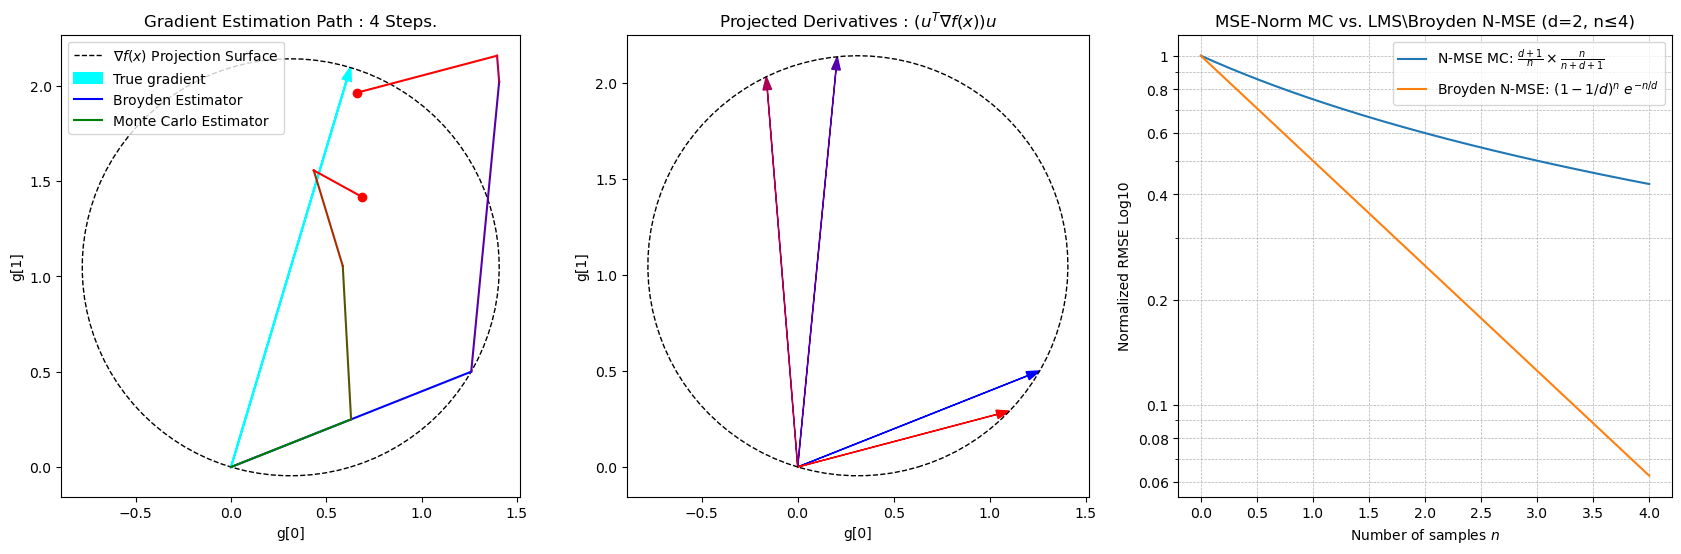

In [212]:
from matplotlib.ticker import FuncFormatter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### COMBINING 2D path demo and LMS exponential convergence rate.
def simulate_and_plot_with_ring(n=50, circle_resolution=200, seed=42):
    np.random.seed(seed)
    # Choose random 2D unit gradient direction
    true_grad = np.random.randn(2)*1.5
    #true_grad #/= np.linalg.norm(true_grad)

    # Generate random unit vectors on the circle (2D sphere)
    U = np.random.randn(n, 2)
    U /= np.linalg.norm(U, axis=1)[:, None]
    c = U.dot(true_grad)

    # Broyden (NLMS) updates
    g_b = np.zeros(2)
    path_b = [g_b.copy()]
    for i in range(n):
        er = c[i] - U[i].dot(g_b) #already normalized
        g_b += er * U[i]
        path_b.append(g_b.copy())
    path_b = np.array(path_b)

    # Monte Carlo smoothing updates
    dims = 2
    g_acc = np.zeros(2)
    path_mc = [np.zeros(2)]
    for i in range(n):
        g_acc += c[i] * U[i] * dims
        tg = g_acc / (i + 1)
        bcorrect =(i + 1) / ((i + dims + 2))#mse adjustment, not using for the example
        gt = tg * bcorrect
        path_mc.append(gt.copy())
    path_mc = np.array(path_mc)

    # Generate unit circle ring
    t = np.linspace(0.0, 1.0 * np.pi, circle_resolution)
    #circ_x, circ_y = np.cos(t), np.sin(t)
    
    u_vecs = np.column_stack((np.cos(t), np.sin(t)))  # (N,2)
    s =  u_vecs @ true_grad #for descent direction   
    ell_x = s * u_vecs[:, 0]
    ell_y = s * u_vecs[:, 1]

    # Set up plot
    fig, axes = plt.subplots(1,3,figsize=(21, 6))#,hspace=0.12,wspace=0.12)
    fig.subplots_adjust(wspace=0.15, hspace=0.11)#,width_ratios=[1,1,1.5])
    ax=axes[0]
    ax.scatter(path_mc[-1, 0], path_mc[-1, 1], color='red')     
    ax.scatter(path_b[-1, 0], path_b[-1, 1], color='red') 
    # Plot unit circle
    ax.plot(ell_x, ell_y, 'k--', linewidth=1, label=r'$\nabla f(x)$ Projection Surface')
    # Plot true gradient direction
    ax.arrow(0,0, true_grad[0],  true_grad[1], linewidth=1.5,head_width=0.045,length_includes_head=True, label='True gradient',color='cyan')

    # Colormaps for lines
    cmap_b = LinearSegmentedColormap.from_list('blue_red', ['blue', 'red'])
    cmap_mc = LinearSegmentedColormap.from_list('purple_green', ['green', 'red'])

        
        # Plot Broyden path (blue->red)
    for i in range(1, len(path_b)):
        color = cmap_b((i - 1) / (n - 1))
        #color = cmap_b(min((i*3 - 3) / (n - 1),.999))
        ax.plot(path_b[i-1:i+1, 0], path_b[i-1:i+1, 1], color=color)
        
        # Plot Monte Carlo path (purple->green)
    for i in range(1, len(path_mc)):
        color = cmap_mc((i - 1) / (n - 1))
        ax.plot(path_mc[i-1:i+1, 0], path_mc[i-1:i+1, 1], color=color)
    

    ax.set_aspect('equal', 'box')
    ax.set_title('Gradient Estimation Path : 4 Steps.')
    ax.set_xlabel('g[0]')
    ax.set_ylabel('g[1]')
    ax.plot([], [], color='blue', label="Broyden Estimator")
    ax.plot([], [], color='green', label="Monte Carlo Estimator")
    ax.legend(loc='upper left')
    
    ax2=axes[1]
    for i in range(n):
        color = cmap_b((i) / (n-1))
        vr=c[i] * U[i]
        ax2.arrow(0, 0, vr[0], vr[1], head_width=0.045, length_includes_head=True,color=color)
    ax2.plot(ell_x, ell_y, 'k--', linewidth=1, label='g Projection Surface')
    ax2.set_aspect('equal', 'box')
    ax2.set_title(r'Projected Derivatives : $(u^T \nabla f(x))u$')
    ax2.set_xlabel('g[0]')
    ax2.set_ylabel('g[1]')
    
    d = 2
    n_max = 4
    n = np.linspace(1/1000, n_max,1000)
    
    # Original MC NRMSE and bias factor
    original_mc_nrmse = np.sqrt((d + 1) / n)
    bias_factor = np.sqrt((n) / (n + d + 1))
    
    # Bias-adjusted MC NRMSE (original rate * bias factor)
    mc_adj_nrmse = (original_mc_nrmse * bias_factor)**2.
    mc_adj_cos=np.sqrt(1- mc_adj_nrmse**2)
    
    # NLMS theoretical NRMSE
    nlms_nrmse = (1 - 1/d) ** (n)
    #a=\left(1-\frac{1}{d}\right)^{-d} and as d increases this converges to e, interesting, but at d=2 its 4.
    #nlms_nrmse2=4**(-n/d) #plots right on top if you test
    nlms_cos=np.sqrt(1- nlms_nrmse**2)
    
    #mc_adj_nrmse=nlms_nrmse2
    
    axes[2].plot(n, mc_adj_nrmse, label=r'N-MSE MC: $\frac{d+1}{n}\times\frac{n}{n+d+1}$')
    axes[2].plot(n, nlms_nrmse, label=r'Broyden N-MSE: $(1 - 1/d)^{n} ~ e^{-n/d}$')
    axes[2].set_xlabel('Number of samples $n$')
    axes[2].set_ylabel('Normalized RMSE Log10')
    axes[2].set_title(r'MSE-Norm MC vs. LMS\Broyden N-MSE (d=2, n≤4)')
    axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[2].margins(y=0.05)
    from matplotlib.ticker import LogLocator,LogFormatter,FuncFormatter
    axes[2].set_yscale('log')
    #axes[2].yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))
    #axes[2].yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10))
    
    # Ensure formatter shows more labels (not just powers of 10)
    axes[2].yaxis.set_major_locator(LogLocator(base=10.0, subs=[.1,*np.arange(1, 5)*0.2], numticks=10))
    axes[2].yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{val:g}"))
    #axes[2].set_yticks(np.linspace(0, 1, 11)) 
    axes[2].grid(True, which="both", ls="--")
    axes[2].legend()
    #axes[2].tight_layout()
    
    plt.show()

# Generate the plot
simulate_and_plot_with_ring(n=4, circle_resolution=100,seed=231)
#107
#160
#165
#197
#209
#223

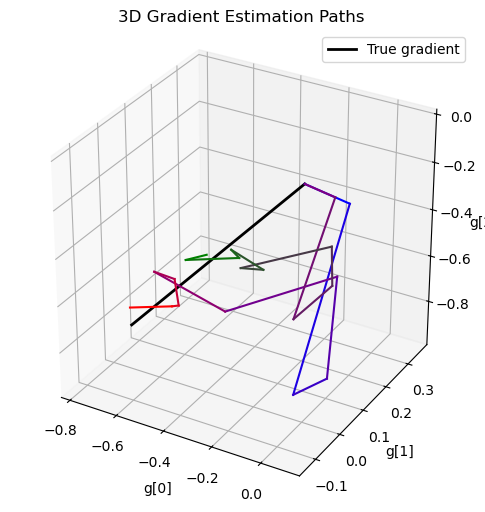

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

def simulate_and_plot_3d(n=50, seed=50):
    np.random.seed(seed)
    # True 3D gradient direction (unit vector)
    true_grad = np.random.randn(3)
    true_grad /= np.linalg.norm(true_grad)

    # Generate n unit vectors on the sphere (3D)
    U = np.random.randn(n, 3)
    U /= np.linalg.norm(U, axis=1)[:, None]
    c = U.dot(true_grad)

    # Broyden (NLMS) updates
    g_b = np.zeros(3)
    path_b = [g_b.copy()]
    for i in range(n):
        er = c[i] - U[i].dot(g_b)
        g_b += er * U[i]
        path_b.append(g_b.copy())
    path_b = np.array(path_b)

    # Monte Carlo smoothing updates
    dims = 3
    g_acc = np.zeros(3)
    path_mc = [np.zeros(3)]
    for i in range(n):
        g_acc += c[i] * U[i] * dims
        tg = g_acc / (i + 1)
        bcorrect = (i + 1) / (.89*(i + dims + 2))
        gt = tg * bcorrect
        path_mc.append(gt.copy())
    path_mc = np.array(path_mc)

    # Plot in 3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    # True gradient direction
    ax.plot([0, true_grad[0]], [0, true_grad[1]], [0, true_grad[2]], 'k-', linewidth=2, label='True gradient')

    # Colormaps
    cmap_b = LinearSegmentedColormap.from_list('blue_red', ['blue', 'red'])
    cmap_mc = LinearSegmentedColormap.from_list('purple_green', ['purple', 'green'])

    # Plot Broyden path
    for i in range(1, len(path_b)):
        ax.plot(path_b[i-1:i+1, 0], path_b[i-1:i+1, 1], path_b[i-1:i+1, 2], color=cmap_b((i-1)/(n-1)))

    # Plot Monte Carlo path
    for i in range(1, len(path_mc)):
        ax.plot(path_mc[i-1:i+1, 0], path_mc[i-1:i+1, 1], path_mc[i-1:i+1, 2], color=cmap_mc((i-1)/(n-1)))

    ax.set_box_aspect([1, 1, 1])
    ax.set_title('3D Gradient Estimation Paths')
    ax.set_xlabel('g[0]')
    ax.set_ylabel('g[1]')
    ax.set_zlabel('g[2]')
    ax.legend()
    plt.show()

simulate_and_plot_3d(10,55)

In [73]:
# Compute and plot a 2D log10(NMSE) heat map for t-quantile approximation vs ground truth.
# Range: p in [0.5, 1 - 1e-9], nu in [1, nu_cut(tol)]
# NOTE: If this times out, you can rerun locally with higher grid sizes.
import math, time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

try:
    import mpmath as mp
except Exception as e:
    raise SystemExit("Please run this locally with `pip install mpmath` for the full heat map.")

# ---------- Approx kernel (same constants as in my drop-in function) ----------
def _invnorm_acklam(p: float) -> float:
    A = (-3.969683028665376e+01,  2.209460984245205e+02,
         -2.759285104469687e+02,  1.383577518672690e+02,
         -3.066479806614716e+01,  2.506628277459239e+00)
    B = (-5.447609879822406e+01,  1.615858368580409e+02,
         -1.556989798598866e+02,  6.680131188771972e+01,
         -1.328068155288572e+01)
    C = (-7.784894002430293e-03, -3.223964580411365e-01,
         -2.400758277161838e+00, -2.549732539343734e+00,
          4.374664141464968e+00,  2.938163982698783e+00)
    D = ( 7.784695709041462e-03,  3.224671290700398e-01,
          2.445134137142996e+00,  3.754408661907416e+00)
    if p <= 0.0 or p >= 1.0:
        if p == 0.0: return -math.inf
        if p == 1.0: return  math.inf
        raise ValueError("p must be in (0,1)")
    plow = 0.02425; phigh = 1 - plow
    if p < plow:
        q = math.sqrt(-2.0*math.log(p))
        return (((((C[0]*q + C[1])*q + C[2])*q + C[3])*q + C[4])*q + C[5]) / \
               ((((D[0]*q + D[1])*q + D[2])*q + D[3])*q + 1.0)
    elif phigh < p:
        q = math.sqrt(-2.0*math.log(1.0 - p))
        return -(((((C[0]*q + C[1])*q + C[2])*q + C[3])*q + C[4])*q + C[5]) / \
                 ((((D[0]*q + D[1])*q + D[2])*q + D[3])*q + 1.0)
    else:
        q = p - 0.5; r = q*q
        return (((((A[0]*r + A[1])*r + A[2])*r + A[3])*r + A[4])*r + A[5]) * q / \
               (((((B[0]*r + B[1])*r + B[2])*r + B[3])*r + B[4])*r + 1.0)

def _stable_sigmoid(x: float) -> float:
    if x >= 50.0:  return 1.0
    if x <= -50.0: return 0.0
    return 1.0 / (1.0 + math.exp(-x))

def tppf_fast(p: float, nu: float, tol: float = 1e-4) -> float:
    if not (0.0 < p < 1.0):
        raise ValueError("p must be in (0,1)")
    if p == 0.5:
        return 0.0
    sign = 1.0
    q = p
    if q < 0.5:
        sign = -1.0
        q = 1.0 - q

    # exact near nu=1
    z = _invnorm_acklam(q)
    t_cauchy = math.tan(math.pi * (q - 0.5))

    # Series kernel with tiny global scale
    u   = z*z
    c1, c2 = 0.5, 0.5
    d1, d2, d3 = 0.125, (11.0/24.0), (1.0/6.0)
    inner = 1.0 + (c1 + c2*u)/nu + (d1 + d2*u + d3*u*u)/(nu*nu)
    a_scale, b_scale = 0.25, 1.2
    t1 = z * math.sqrt(inner) * (1.0 + a_scale / (nu + b_scale))

    # Tail inversion
    s = 1.0 - q
    logK = -math.log(nu) - (math.lgamma(nu/2.0) + 0.5*math.log(math.pi) - math.lgamma((nu+1.0)/2.0))
    h = (2.0/nu) * (logK - math.log(s))
    w = math.expm1(h) if abs(h) < 1e-5 else math.exp(h) - 1.0
    t2 = math.sqrt(max(0.0, nu * w))

    # Blend
    K_SWITCH = 4.0
    eps = 1e-300
    m_tail = _stable_sigmoid(K_SWITCH * math.log((t2 + eps)/(t1 + eps)))
    t = (1.0 - m_tail) * t1 + m_tail * t2

    # Cauchy smoothing
    if nu <= 1.25:
        wC = max(0.0, min(1.0, (1.25 - nu)/0.25))
        t = wC * t_cauchy + (1.0 - wC) * t

    # z fallback
    zmax = 6.109410204869
    nu_cut = max(5.0, ( (zmax**3 + zmax) / (4.0 * tol) ))
    K_ZBLEND = 8.0
    wZ = _stable_sigmoid( K_ZBLEND * ((nu - nu_cut)/nu_cut) )
    t = (1.0 - wZ)*t + wZ*z

    return sign * t

# ---------- Ground truth (regularized incomplete beta + bisection) ----------
def t_cdf_true(x, nu):
    if x == 0: return mp.mpf('0.5')
    if x > 0:
        x2 = nu/(nu + x*x)
        I = mp.betainc(nu/2, 0.5, 0, x2, regularized=True)
        return 1 - 0.5*I
    else:
        return 1 - t_cdf_true(-x, nu)

def t_ppf_true(p, nu):
    # symmetry
    if p <= 0: return -mp.inf
    if p >= 1: return  mp.inf
    if p == 0.5: return mp.mpf('0')
    neg = p < 0.5
    if neg: p = 1 - p
    s = 1 - p
    # tail-based ub
    logK = -mp.log(nu) - (mp.loggamma(nu/2) + mp.log(mp.pi)/2 - mp.loggamma((nu+1)/2))
    h = (2/nu)*(logK - mp.log(s))
    tail_term = mp.e**h - 1
    ub = mp.sqrt(nu * tail_term) if tail_term > 0 else mp.mpf('10')
    lb = mp.mpf('0')
    # make sure we bracket
    for _ in range(60):
        if t_cdf_true(ub, nu) < p:
            ub *= 2
        else:
            break
    # bisection
    for _ in range(200):
        mid = (lb+ub)/2
        if t_cdf_true(mid, nu) < p:
            lb = mid
        else:
            ub = mid
    q = (lb+ub)/2
    return -q if neg else q

# ---------- Grid & NMSE ----------
tol = 1e-4
zmax = 6.109410204869
nu_cut = max(5.0, ((zmax**3 + zmax) / (4.0 * tol)))

# Adjust grid sizes here. If slow, reduce NX/NY.
NX = 180   # p-grid (0.5 .. 1-1e-9)
NY = 140   # nu-grid (1 .. nu_cut)

ps = np.linspace(0.5, 1.0 - 1e-9, NX, dtype=float)
nus = np.linspace(1.0, float(nu_cut), NY, dtype=float)

heat = np.empty((NY, NX), dtype=float)
start = time.time()
for j, nu in enumerate(nus):
    for i, p in enumerate(ps):
        t_star = float(t_ppf_true(p, nu))
        t_app  = tppf_fast(p, nu, tol=tol)
        # normalized pointwise MSE = relative squared error
        denom = max(abs(t_star), 1e-300)
        nmse = ((t_app - t_star)/denom)**2
        heat[j, i] = nmse
    # crude progress print every ~10 rows
    if (j+1) % 10 == 0:
        print(f"row {j+1}/{NY}  elapsed {time.time()-start:.1f}s")

# ---------- Plot (log10 NMSE) ----------
fig = plt.figure(figsize=(14, 8))  # large as requested
ax = plt.gca()
# Log scale; clip tiny values to avoid -inf
log_heat = np.log10(np.clip(heat, 1e-18, None))
im = ax.imshow(log_heat, aspect='auto', origin='lower',
               extent=[ps[0], ps[-1], nus[0], nus[-1]])
cb = plt.colorbar(im)
cb.set_label("log10(NMSE)  =  log10( ((t_app - t_true)/t_true)^2 )")
ax.set_xlabel("p (one-sided quantile)")
ax.set_ylabel("Degrees of freedom (nu)")
ax.set_title("t-Quantile Approximation: log10 NMSE over (p, nu)")
plt.show()

KeyboardInterrupt: 

1.0
1 0.15865525393145707
3 0.0013498980316301035
6 9.865877004244794e-10


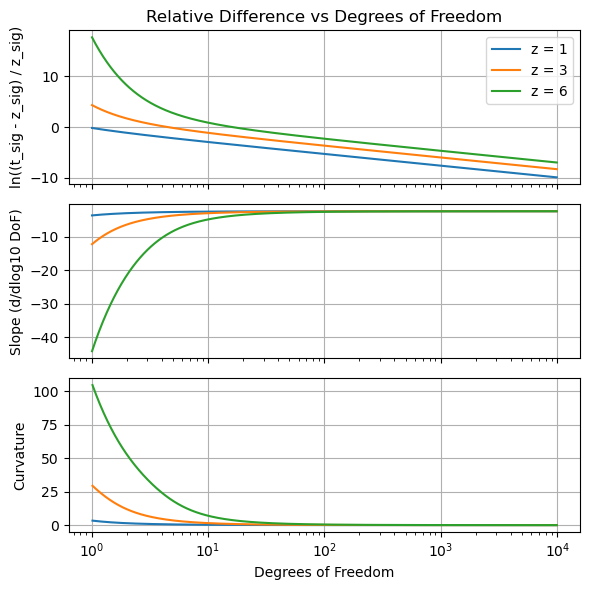

In [118]:
from scipy.stats import norm,t
# Prepare data for multiple z-scores
z_values = [1, 3, 6,]

# Degrees of freedom range
dof_values = np.logspace(np.log10(1.), np.log10(10000), 1000)
dof_values = np.clip(dof_values, 1, None)
print(dof_values[0])

# Container for results
results = {}

# Loop through z-values
for z_sig in z_values:
    p_value = 1 - norm.cdf(z_sig,)# df=1e6)  # approximate normal
    print(z_sig,p_value)
    t_scores = t.ppf(1 - p_value, df=dof_values)
    y_values = np.log((t_scores - z_sig) / z_sig)
    #y_values = np.log((np.log(t_scores) - np.log(z_sig)) / z_sig)
    results[z_sig] = y_values

# Create figure
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

s1,s2=1,-1
# Top plot: y-values
for z_sig in z_values:
    axes[0].plot(dof_values[s1:s2], results[z_sig][s1:s2], label=f'z = {z_sig}')
axes[0].set_xscale('log')
axes[0].set_ylabel('ln((t_sig - z_sig) / z_sig)')
axes[0].set_title('Relative Difference vs Degrees of Freedom')
axes[0].grid(True)
axes[0].legend()

# Middle plot: slope (first derivative w.r.t. log10(DoF))
for z_sig in z_values:
    slope = np.gradient(results[z_sig], np.log10(dof_values))
    axes[1].plot(dof_values[s1:s2], slope[s1:s2], label=f'z = {z_sig}')
axes[1].set_xscale('log')
axes[1].set_ylabel('Slope (d/dlog10 DoF)')
axes[1].grid(True)

# Bottom plot: curvature (second derivative w.r.t. log10(DoF))
for z_sig in z_values:
    slope = np.gradient(results[z_sig], np.log10(dof_values))
    curvature = np.gradient(slope, np.log10(dof_values))
    axes[2].plot(dof_values[s1+1:s2], curvature[s1+1:s2], label=f'z = {z_sig}')
axes[2].set_xscale('log')
axes[2].set_xlabel('Degrees of Freedom')
axes[2].set_ylabel('Curvature')
axes[2].grid(True)

plt.tight_layout()
plt.show()

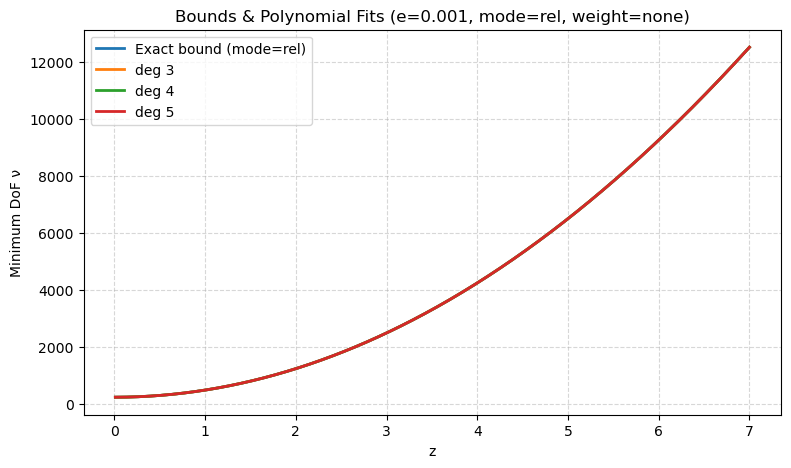

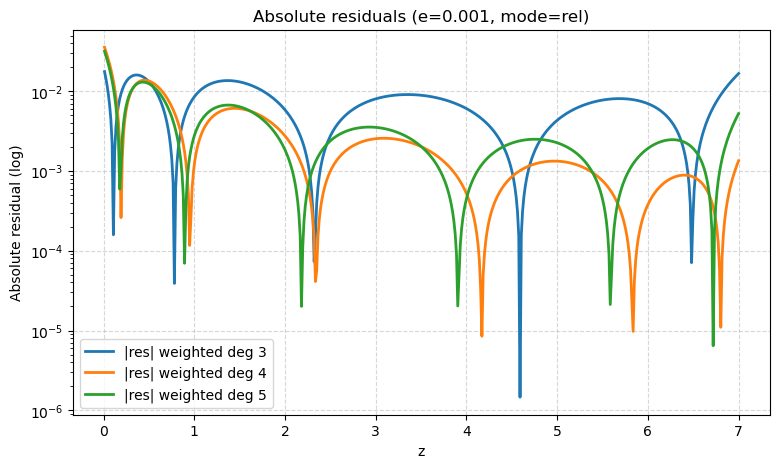

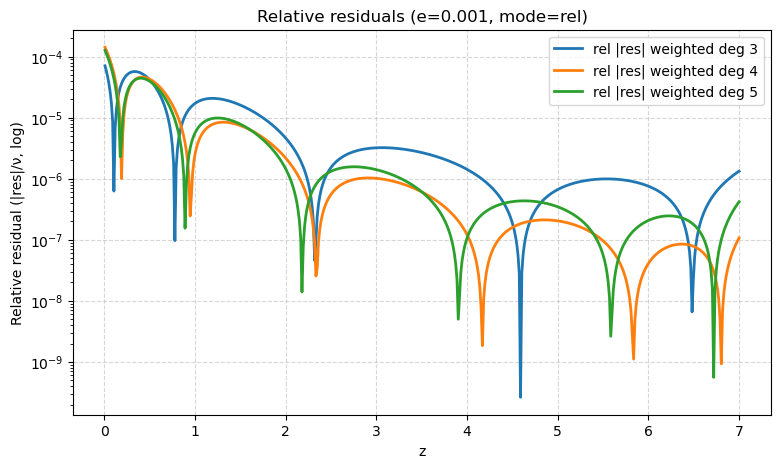

Max relative error by degree: {'weighted_deg_3_max_relerr': 7.053275345959626e-05, 'weighted_deg_4_max_relerr': 0.00014249281124695896, 'weighted_deg_5_max_relerr': 0.0001268951561473426}


In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as student_t, norm

# --- solver (same robust sf-based) ---
def min_df_bound_sf(z, e, mode="abs", nu_min=1e-12, nu_max=1e12, rel_tol=1e-10, abs_tol=1e-12, max_iter=300):
    if e <= 0:
        raise ValueError("e must be positive.")
    if z <= 0:
        return 0.0, 0.0

    x = (z + e) if mode == "abs" else (z * (1.0 + e))
    target_sf = norm.sf(z)

    def g(nu):
        return student_t.sf(x, df=nu) - target_sf  # decreasing in nu

    nu_lo = max(nu_min, 1e-12)
    g_lo = g(nu_lo)
    if g_lo <= 0:
        return nu_lo, g_lo

    nu_hi = nu_lo
    g_hi = g_lo
    while g_hi > 0 and nu_hi < nu_max:
        nu_hi *= 2.0
        g_hi = g(nu_hi)

    if g_hi > 0:
        return np.nan, np.nan

    it = 0
    while it < max_iter and (nu_hi - nu_lo) > max(abs_tol, rel_tol * max(1.0, nu_hi)):
        nu_mid = 0.5 * (nu_lo + nu_hi)
        g_mid = g(nu_mid)
        if g_mid <= 0:
            nu_hi = nu_mid
        else:
            nu_lo = nu_mid
        it += 1

    return nu_hi, g(nu_hi)


# --- main routine with weighted fits ---
def compute_and_fit_weighted(
    e_fixed=1e-4,
    z_vals=np.linspace(0.01, 3.0, 500),
    mode="abs",
    degrees=(3, 4, 5),
    weight_mode="none",       # 'none' or 'relative'
    also_show_unweighted=True,    # overlay unweighted for comparison
):
    # 1) compute bounds
    bounds = np.empty_like(z_vals, dtype=float)
    final_errs = np.empty_like(z_vals, dtype=float)
    for i, z in enumerate(z_vals):
        nu_star, g_end = min_df_bound_sf(z, e_fixed, mode=mode)
        bounds[i] = nu_star
        final_errs[i] = g_end

    # 2) choose weights
    eps = 1e-30
    if weight_mode == "relative":
        # minimize sum ((pred-ν)/ν)^2  ==> weights w = 1/ν^2
        w = 1.0 / np.maximum(bounds, eps)**2
    else:
        w = None  # ordinary least squares

    # 3) fits
    fits_w = {}
    preds_w = {}
    for d in degrees:
        coeffs = np.polyfit(z_vals, bounds, deg=d, w=None if w is None else np.log(np.sqrt(w)))
        fits_w[d] = coeffs
        preds_w[d] = np.polyval(coeffs, z_vals)

    fits_un = {}
    preds_un = {}
    if also_show_unweighted:
        for d in degrees:
            c = np.polyfit(z_vals, bounds, deg=d)
            fits_un[d] = c
            preds_un[d] = np.polyval(c, z_vals)

    # 4) plots
    # Bounds + fits
    plt.figure(figsize=(9, 5))
    plt.plot(z_vals, bounds, label=f"Exact bound (mode={mode})", lw=2)
    for d in degrees:
        lbl = f"weighted deg {d}" if weight_mode != "none" else f"deg {d}"
        plt.plot(z_vals, preds_w[d], label=lbl, linewidth=2)
    if also_show_unweighted:
        for d in degrees:
            plt.plot(z_vals, preds_un[d], linestyle="--", label=f"unweighted deg {d}")
    plt.xlabel("z")
    plt.ylabel("Minimum DoF ν")
    plt.title(f"Bounds & Polynomial Fits (e={e_fixed}, mode={mode}, weight={weight_mode})")
    plt.grid(True, ls="--", alpha=0.5)
    plt.legend()
    plt.show()

    # Absolute residual lines (log y)
    plt.figure(figsize=(9, 5))
    for d in degrees:
        res = np.abs(preds_w[d] - bounds)
        plt.plot(z_vals, res, label=f"|res| weighted deg {d}", linewidth=2)
    if also_show_unweighted:
        for d in degrees:
            res = np.abs(preds_un[d] - bounds)
            plt.plot(z_vals, res, linestyle="--", label=f"|res| unweighted deg {d}")
    plt.yscale("log")
    plt.xlabel("z")
    plt.ylabel("Absolute residual (log)")
    plt.title(f"Absolute residuals (e={e_fixed}, mode={mode})")
    plt.grid(True, ls="--", alpha=0.5)
    plt.legend()
    plt.show()

    # Relative residual lines (log y)
    plt.figure(figsize=(9, 5))
    safe = np.where(bounds > 0, bounds, np.nan)
    for d in degrees:
        rel = np.abs(preds_w[d] - bounds) / safe
        plt.plot(z_vals, rel, label=f"rel |res| weighted deg {d}", linewidth=2)
    if also_show_unweighted:
        for d in degrees:
            rel = np.abs(preds_un[d] - bounds) / safe
            plt.plot(z_vals, rel, linestyle="--", label=f"rel |res| unweighted deg {d}")
    plt.yscale("log")
    plt.xlabel("z")
    plt.ylabel("Relative residual (|res|/ν, log)")
    plt.title(f"Relative residuals (e={e_fixed}, mode={mode})")
    plt.grid(True, ls="--", alpha=0.5)
    plt.legend()
    plt.show()

    # 5) summary metrics (max rel err) for quick sanity
    summary = {}
    for d in degrees:
        rel_w = np.nanmax(np.abs(preds_w[d] - bounds) / safe)
        summary[f"weighted_deg_{d}_max_relerr"] = rel_w
        if also_show_unweighted:
            rel_un = np.nanmax(np.abs(preds_un[d] - bounds) / safe)
            summary[f"unweighted_deg_{d}_max_relerr"] = rel_un

    print("Max relative error by degree:", summary)

    return {
        "z_vals": z_vals,
        "bounds": bounds,
        "final_errs": final_errs,
        "fits_weighted": fits_w,
        "preds_weighted": preds_w,
        "fits_unweighted": fits_un,
        "preds_unweighted": preds_un,
        "summary": summary,
    }

# Run: drop deg 2; use relative weighting; keep bounds; show residuals incl. relative
out_w = compute_and_fit_weighted(
    e_fixed=1e-3,
    z_vals=np.linspace(0.01, 7, 500),
    mode="rel",
    degrees=(3,4,5),
    weight_mode="none",
    also_show_unweighted=False,
)


In [9]:
import math as mt
d=2000
mt.log1p(-1/d)

-0.0005001250416822979

In [12]:
mt.log(.999)

-0.0010005003335835344